<a href="https://colab.research.google.com/github/jonahcoutinho/celebrity_classification_engine/blob/master/Athlete_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_digits
import cv2
from sklearn.model_selection import cross_val_score

In [4]:
face_cascade=cv2.CascadeClassifier('/content/drive/MyDrive/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade=cv2.CascadeClassifier('/content/drive/MyDrive/haarcascades/haarcascade_eye.xml')


Now we have detected the face. so we draw a rectangle around it


ROI is the region of interest
so now we try and isolate only faces for the images


*******************Start main code here***************************************

Now we need to make a funtion to perform these operation to crop all images. 

Its the same code but for a larger scale:

Lets do it!


In [5]:
face_cascade=cv2.CascadeClassifier('/content/drive/MyDrive/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade=cv2.CascadeClassifier('/content/drive/MyDrive/haarcascades/haarcascade_eye.xml')

In [6]:
def get_cropped_image_if_2_eyes(image_path):
  img = cv2.imread(image_path)
  gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces=face_cascade.detectMultiScale(gray,1.3,5)
  for (x,y,w,h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    if(len(eyes)>=2):
      return roi_color




In [7]:
cropped_image=get_cropped_image_if_2_eyes('/content/drive/MyDrive/images_dataset/roger_federer/07548250.jpg')

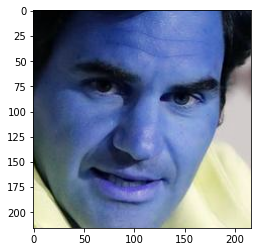

In [8]:
plt.imshow(cropped_image)

In [9]:
import os
img_dirs=[]
for entry in os.scandir('/content/drive/MyDrive/images_dataset/'):
  if entry.is_dir():
    img_dirs.append(entry.path)

In [10]:
img_dirs

['/content/drive/MyDrive/images_dataset/lionel_messi',
 '/content/drive/MyDrive/images_dataset/maria_sharapova',
 '/content/drive/MyDrive/images_dataset/virat_kohli',
 '/content/drive/MyDrive/images_dataset/roger_federer',
 '/content/drive/MyDrive/images_dataset/serena_williams',
 '/content/drive/MyDrive/images_dataset/.ipynb_checkpoints']

we have the file names in img_dirs
cropped folder=
/content/drive/MyDrive/images_dataset/cropped

In [11]:
path_to_cr_data='/content/drive/MyDrive/imades_dataset_cropped/'
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

we create a dict so that we can map the celeb to its individual cropped images. and we have to preinitialise it as given

In [12]:
cropped_image_dirs=[]
celebrity_file_names_dict={}

for img_dir in img_dirs:
  count=1
  celebrity_name=img_dir.split('/')[-1]

  celebrity_file_names_dict[celebrity_name]=[]

  for entry in os.scandir(img_dir):
    roi_color=get_cropped_image_if_2_eyes(entry.path)
    if roi_color is not None:
      cropped_folder=path_to_cr_data+celebrity_name
      
      if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder) 
        cropped_image_dirs.append(cropped_folder)
        print('....',cropped_folder)
      cropped_file_name=celebrity_name+str(count)+".png"
      cropped_file_path=cropped_folder+'/'+cropped_file_name
      cv2.imwrite(cropped_file_path,roi_color)
      celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
      count+=1

.... /content/drive/MyDrive/imades_dataset_cropped/lionel_messi
.... /content/drive/MyDrive/imades_dataset_cropped/maria_sharapova
.... /content/drive/MyDrive/imades_dataset_cropped/virat_kohli
.... /content/drive/MyDrive/imades_dataset_cropped/roger_federer
.... /content/drive/MyDrive/imades_dataset_cropped/serena_williams


In [29]:
print(celebrity_file_names_dict)

{'lionel_messi': ['/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi1.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi2.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi3.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi4.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi5.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi6.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi7.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi8.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi9.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi10.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi11.png', '/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi12.png', '/content/drive/MyD

Thats it with cleaning. 

Now manually remove wrong images from folder


Now We wavelet transform for extracting meaning from the image

In [31]:
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

Basically we deconstruct and reconstruct the image as follows:


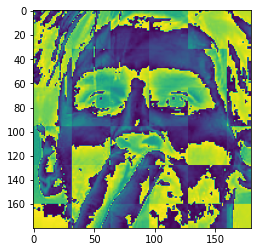

In [32]:
image=cv2.imread('/content/drive/MyDrive/imades_dataset_cropped/lionel_messi/lionel_messi1.png')
h=w2d(image,'db1',5)
plt.imshow(h)

In [ ]:
del celebrity_file_names_dict['.ipynb_checkpoints']

In [34]:
celebrity_file_names_dict.keys()

dict_keys(['lionel_messi', 'maria_sharapova', 'virat_kohli', 'roger_federer', 'serena_williams'])

In [35]:
#we gotta store the names of the celebrities in y but in the form of numbers
count=0
class_dict={}
for celebrity_name in celebrity_file_names_dict.keys():
  class_dict[celebrity_name]=count
  count=count+1
class_dict  

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 3,
 'serena_williams': 4,
 'virat_kohli': 2}

Now we can map appropriately

In [64]:
X=[]
y=[]
for celebrity_name,training_files in celebrity_file_names_dict.items():
  for training_image in training_files:
    img=cv2.imread(training_image)
    if(img is None):
      continue
    #images can be of diiferent size so just resize

    scalled_raw_image=cv2.resize(img,(32,32))
    img_har=w2d(img,'db1',5)
    scalled_img_har=cv2.resize(img_har,(32,32))

    #we basically want to vertically stack both these images one above the other using stack fucntion in numpy

    combined_img=np.vstack((scalled_raw_image.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    X.append(combined_img)
    y.append(class_dict[celebrity_name])


In [37]:
len(X)

168

In [38]:
len(y)

168

In [39]:
32*32*3+32*32

4096

now lets reshape X to an array

In [40]:
X=np.array(X).reshape(len(X),4096).astype(float)
X

array([[100., 129., 140., ..., 237., 234., 232.],
       [131., 125., 130., ...,   3., 101., 249.],
       [228., 223., 222., ...,   0.,   0.,   0.],
       ...,
       [239., 229., 229., ...,  56.,   9., 230.],
       [  1.,  52., 113., ...,  24., 152.,  63.],
       [ 34.,  34.,  49., ...,   2., 253., 252.]])

Now lets start modeling 

In [41]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,random_state=0)


In [79]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler
clf=Pipeline([('scalar',StandardScaler()),('svc',SVC(kernel='rbf',C=10,probability=True))])
clf.fit(xtrain,ytrain)
clf.score(xtest,ytest)

0.9523809523809523

In [43]:
#lets see the classificationn report
from sklearn.metrics import classification_report
print(classification_report(ytest,clf.predict(xtest)))
print(confusion_matrix(ytest,clf.predict(xtest)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.90      0.95        10
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         4
           4       1.00      0.89      0.94         9

    accuracy                           0.95        42
   macro avg       0.96      0.96      0.95        42
weighted avg       0.96      0.95      0.95        42

[[ 7  0  0  0  0]
 [ 1  9  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0  4  0]
 [ 1  0  0  0  8]]


HyperParameter tuning with different models


In [44]:
model_params={
    'svm':{
        'model':SVC(),
            'params': {
            'kernel':['linear','rbf','poly'],
            'C':[1,10,20], 
            'gamma': [0.001, 0.0001,'auto']
                  }
           },
           'random_forest':{
        'model':RandomForestClassifier(),
            'params':{
            'n_estimators':[1,5,10],
            'criterion':['gini','entropy'], 
            'max_depth': [5,10,20]
                  }
           },
             'logistic_regression':{
        'model':LogisticRegression(),
            'params':{
            'solver':['newton-cg','lbfgs','saga','liblinear'],
            'multi_class':['auto', 'ovr', 'multinomial'], 
            'C': [1,5,10]
                  }
           }
}



In [45]:

scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    #pipe = make_pipeline(StandardScaler(), )
    StandardScaler().fit(xtrain,ytrain)
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(xtrain, ytrain)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,model,best_score,best_params
0,svm,0.769846,"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}"
1,random_forest,0.651692,"{'criterion': 'gini', 'max_depth': 20, 'n_esti..."
2,logistic_regression,0.817846,"{'C': 1, 'multi_class': 'auto', 'solver': 'new..."


In [46]:
best_estimators

{'logistic_regression': LogisticRegression(C=1, solver='newton-cg'),
 'random_forest': RandomForestClassifier(max_depth=20, n_estimators=5),
 'svm': SVC(C=1, gamma=0.001, kernel='linear')}

In [47]:
best_estimators['svm'].score(xtest,ytest)

0.9761904761904762

In [48]:
best_clf=best_estimators['svm']

In [51]:
print(confusion_matrix(ytest,best_clf.predict(xtest)))

[[ 7  0  0  0  0]
 [ 1  9  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0  4  0]
 [ 0  0  0  0  9]]


In [52]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 3,
 'serena_williams': 4,
 'virat_kohli': 2}

In [54]:
import pickle
with open('celeb_model.pickle','wb') as f:
  pickle.dump(best_clf,f)



In [57]:
load=pickle.load(open('celeb_model.pickle','rb'))

In [58]:
load.predict('/content/drive/MyDrive/images_dataset/lionel_messi/10_MESSI_JUGADORS-WEB.jpg')

ValueError: ignored

In [ ]:
load.score(xtest,ytest)

In [ ]:
import json
with open('class_dictionary.json','w') as f:
  f.write(json.dumps(class_dict))



NOW LETS TEST!

In [81]:
imgs=[]
imgs=get_cropped_image_if_2_eyes('/content/drive/MyDrive/imades_dataset_cropped/roger_federer/roger_federer6.png')
for img in imgs:
  scalled_raw_image = cv2.resize(img, (32, 32))
  img_har = w2d(img, 'db1', 5)
  scalled_img_har = cv2.resize(img_har, (32, 32))

        # we basically want to vertically stack both these images one above the other using stack fucntion in numpy

  combined_img = np.vstack((scalled_raw_image.reshape(32 * 32 * 3, 1), scalled_img_har.reshape(32 * 32, 1)))
  len_image=32*32*3+32*32
  final = combined_img.reshape(1, len_image).astype(float)
clf.predict_proba(final)   

array([[0.07097466, 0.48531569, 0.02316719, 0.38859332, 0.03194915]])

In [69]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [68]:
def get_cropped_image_if_2_eyes(image_path):
  face_cascade=cv2.CascadeClassifier('/content/drive/MyDrive/haarcascades/haarcascade_frontalface_default.xml')
  eye_cascade=cv2.CascadeClassifier('/content/drive/MyDrive/haarcascades/haarcascade_eye.xml') 
  if image_path:
    img=cv2.imread(image_path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    cropped_faces=[]  #all faces in img
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = img[y:y + h, x:x + w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if (len(eyes) >= 2):
            cropped_faces.append(roi_color)
    return cropped_faces